## Layers

케라스에선 많은 layer를 지원합니다.

물론 특정 상황에서만 사용하는 layer들이 있지만,(예를 들어 풀링,rnn 등등)

이번엔 보편적으로 사용되는 __전처리__ 관련 layer들을 알아보자.

### Nomalization

정규화를 진행해줍니다

이 층의 특징은 adapt 메소드가 선행되어야하는 점입니다


In [65]:
import keras
from zipfile import ZipFile
import pandas as pd
import io
with ZipFile("../Data/고객 대출등급 분류 해커톤.zip","r") as f:
    data=io.BytesIO(f.read("고객 대출등급 분류 해커톤/train.csv"))
from sklearn import model_selection as mod
import numpy as np
import tensorflow as tf

data=pd.read_csv(data)

In [2]:
nomalization=keras.layers.Normalization()

특정 데이터 특성을 살펴보면 다음과 같습니다.

In [11]:
cols=["대출금액","연간소득","총상환원금"]

In [79]:
dataset=tf.data.Dataset.from_tensor_slices(data[cols].values)

In [80]:
for i in dataset.take(3):
    print(i)

tf.Tensor([12480000 72000000        0], shape=(3,), dtype=int64)
tf.Tensor([ 14400000 130800000    373572], shape=(3,), dtype=int64)
tf.Tensor([12000000 96000000   928644], shape=(3,), dtype=int64)


2025-01-15 19:03:14.306827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
data[cols].describe().loc[["mean","std"]]

,대출금액,연간소득,총상환원금
mean,1.830400e+07,9.392672e+07,8.225035e+05
std,1.032908e+07,9.956871e+07,1.027745e+06


nomarlization 은 이를 adapt를 통해 계산합니다

In [84]:
nomalization.adapt(data[cols].values)

In [30]:
print("평균 :", nomalization.mean)
print("분산(var) :", nomalization.variance)

평균 : tf.Tensor([[18303998.  93926728.    822503.5]], shape=(1, 3), dtype=float32)
분산(var) : tf.Tensor([[1.06688699e+14 9.91382497e+15 1.05624935e+12]], shape=(1, 3), dtype=float32)


`adapt`는 Tensorflow Dataset 을 적용해도 잘 작동합니다

믈론 우리는 그 외의 BatchNomalization 을 살펴봤으며, 해당층은 위의 값을 추정하는 단계를 거침을 알고있습니다

### Discretization

범주화 레이어는 수치형 특성을 범주형으로 변환합니다

In [40]:
from matplotlib import pyplot as plt
from scipy import stats as sts

In [44]:
kde=sts.gaussian_kde(data[cols[0]])
x_axis=np.linspace(min(data[cols[0]]),max(data[cols[0]]),1000)

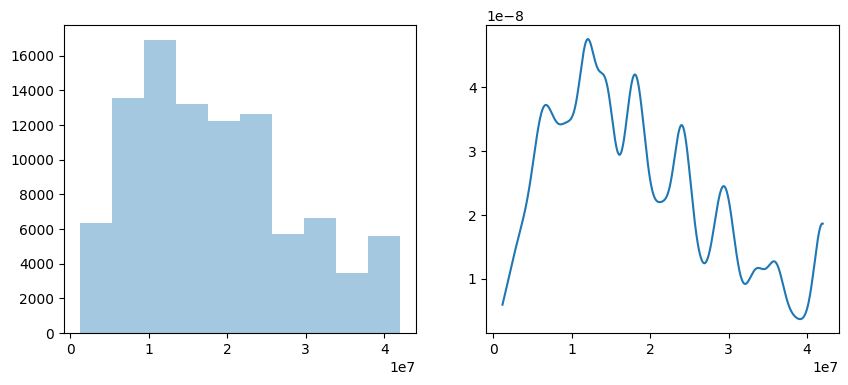

In [59]:
_,a=plt.subplots(1,2,figsize=(10,4))
a[0].hist(data[cols[0]],alpha=0.4)
a[1].plot(x_axis,kde(x_axis))

위와 같은 다중모드 분포를 가진 특성이나 비선형 데이터를 처리하기 좋은 층입니다.

구간의 개수를 정해주면, 적당한 구간을 찾아 기억합니다

In [91]:
discretize=keras.layers.Discretization(num_bins=7)

In [92]:
discretize.adapt(dataset.map(lambda x:x[0]))

2025-01-16 15:22:03.979365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [96]:
discretiaze(data[cols[0]][1000:1200])

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([0, 2, 0, 4, 3, 0, 2, 0, 2, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 3, 2, 0,
       3, 0, 0, 1, 0, 2, 0, 3, 1, 3, 0, 0, 0, 2, 5, 2, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 6, 2, 0, 0, 0, 2, 6, 1, 2, 0, 0, 3, 0, 0, 6, 0, 2, 0,
       6, 4, 0, 5, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 1, 0, 0, 0, 3,
       1, 0, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 3, 0, 4, 3, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 6, 0, 1, 0, 2, 2, 4, 0, 5, 2, 2, 6, 0, 0, 0, 4,
       1, 1, 0, 3, 2, 0, 6, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4,
       1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0,
       2, 2, 6, 6, 0, 3, 0, 1, 0, 0, 0, 3, 0, 0, 1, 0, 0, 6, 2, 0, 0, 0,
       0, 0])>

In [100]:
# 아래의 값을 기준으로 나눴음을 알 수 있습니다.
discretize.bin_boundaries

[18020726.0, 23431066.0, 28094256.0, 32622852.0, 36510908.0, 40326664.0]

### CategoryEncoding

범주의 개수가 일반적으로 10~20개 사이라면 `One-Hot` encoding은 좋은 선택이 됩니다.

위의 discretization layer를 통해 범주화한 데이터의 비교는 큰 의미를 가지지 못하니, encoding 해서 사용합니다.

In [102]:
encoding=keras.layers.CategoryEncoding(num_tokens=7)

In [104]:
encoding(discretiaze(data[[cols[0]]][1000:1200]))

<tf.Tensor: shape=(200, 7), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

categoryEncoding layer는 기본적으로 multi-hot encoding을 구현합니다

예를 들어

In [112]:
encoding=keras.layers.CategoryEncoding(output_mode="multi_hot",num_tokens=3)
multi=tf.constant(
    [[1,2],[0,1],[1,1]]
)
encoding(multi)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [1., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

각 범주의 개수를 알고싶다면 다음과 같이 설정할 수 있습니다.

In [115]:
encoding=keras.layers.CategoryEncoding(output_mode="count",num_tokens=3)
multi=tf.constant(
    [[1,2],[0,1],[1,1]]
)
encoding(multi)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [1., 1., 0.],
       [0., 2., 0.]], dtype=float32)>

> 참고 : multi-hot 은 동일한 범주를 가지고 있다는 가정이 필수입니다

### StringLookup

이는 텍스트로 된 범주형 데이터의 encoding을 지원합니다

In [117]:
data["대출목적"].unique()

array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)

In [118]:
stringlookup=keras.layers.StringLookup()

In [119]:
stringlookup.adapt(data["대출목적"])

다음과 같이 텍스트 범주들을 기억합니다

In [121]:
print(stringlookup.get_vocabulary())

['[UNK]', '부채 통합', '신용 카드', '주택 개선', '기타', '주요 구매', '의료', '자동차', '소규모 사업', '이사', '휴가', '주택', '재생 에너지']


In [124]:
stringlookup(data[["대출목적"]][:5])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1],
       [3],
       [1],
       [1],
       [5]])>

In [126]:
# one-hot encoding 도 지원합니다
stringlookup=keras.layers.StringLookup(output_mode="one_hot")
stringlookup.adapt(data["대출목적"])
stringlookup(data[["대출목적"]][:5])

<tf.Tensor: shape=(5, 13), dtype=int64, numpy=
array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])>

데이터가 너무 크다면 우리는 adapt를 통한 vocabulary를 형성하기 어려울 수 있습니다.

이때 쓰이는 선택은 샘플을 추출해 학습시키는 것인데, 미처 학습하지 못한 범주는 unknown으로 모두 매핑되는 문제가 생깁니다.

이를 방지하는 기술은 `oov(out of vocabulary)`의 개수를 증가시키는 것입니다.

In [132]:
stringlookup=keras.layers.StringLookup(num_oov_indices=3)
stringlookup.adapt(data[["대출목적"]][:10])

In [133]:
print(stringlookup.get_vocabulary())

['[UNK]', '[UNK]', '[UNK]', '부채 통합', '휴가', '주택 개선', '주요 구매', '자동차', '의료']


위의 `[unk]` 토큰의 개수가 늘었음을 알 수 잇습니다.

즉 모르는 범주를 만났을 때 해시 함수를 통해 0,1,2 값 중 하나의 값에 매핑됩니다.

하지만 "재생에너지","소규모 사업" 등의 모르는 범주가 같은 값으로 매핑될 가능성이 있는데

이를 `Hashing Collision` 이라 부릅니다(해싱충돌)

결국 oov의 개수를 늘려서 방지할 수 있지만 범주의 개수가 늘어나므로, 너무 늘리지 않는 것을 추천드립니다

### Embedding 

학습가능한 Encoding 입니다.

Enbedding Matrix는 범주마다 하나의 행을, 임베딩 차원마다 하나의 열을 가집니다.

예를 들어보죠.

In [139]:
embd=keras.layers.Embedding(input_dim=13,output_dim=2)

stringlookup=keras.layers.StringLookup()
stringlookup.adapt(data["대출목적"])
stringlookup(data[["대출목적"]][:5])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1],
       [3],
       [1],
       [1],
       [5]])>

In [142]:
embd(stringlookup(data[["대출목적"]][:5]))

<tf.Tensor: shape=(5, 1, 2), dtype=float32, numpy=
array([[[-0.03990493, -0.00949565]],

       [[-0.0214159 ,  0.00337709]],

       [[-0.03990493, -0.00949565]],

       [[-0.03990493, -0.00949565]],

       [[ 0.02032805,  0.0084204 ]]], dtype=float32)>

보통은 10~300차원으로 매핑하며, 이는 튜닝해야하는 하이퍼 파라미터입니다